# Tutorial 5: Gradient-Enhanced Gaussian Process Model 

In this notebook, we will walk through the functionalities of the developed package related to training and exploiting a gradient-enhanced Gaussian Process model for interpolation purposes. 

For a theoretical introduction of the gradient-enhanced Gaussian Process modeling, see: [A. Forrester, A. J. Keane, Recent advances in surrogate-based optimization, *Progress in Aerospace Sciences*, 2009, 45(1), pp. 50-79.](http://www.sciencedirect.com/science/article/pii/S0376042108000766).

If you have further questions, please contact Shuai Guo at guo@tfd.mw.tum.de

In [1]:
# Get path right
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

In [2]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Import sampler
from skopt.space import Space
from skopt.sampler import Lhs

# Import Gradient-Enhanced GP module
from GEGP import GEGP

%matplotlib inline

In [3]:
lhs = Lhs(criterion="maximin")
x = np.array(lhs.generate([(-2.,2.),(0.,5.)], 10))

## 1. Testing function (1D)

### 1.1 Analytical function

In this tutorial, we consider the following reference function:

\begin{equation}
y = (6x-2)^2sin(12x-4), x \in [0,1]
\end{equation}

### 1.2 Generating training dataset

In [4]:
X_train=np.array([0,0.1, 0.2,0.4,0.6,0.8, 1]).reshape(-1,1)
y_train =((6*X_train-2)**2)*np.sin(12*X_train-4)
grad_train = 12*(6*X_train-2)*np.sin(12*X_train-4) + \
    ((6*X_train-2)**2)*np.cos(12*X_train-4)*12

### 1.3 Initiate a gradient-enhanced GP model

To train agradient-enhanced Gaussian Process (GEGP) model and later use it for performing interpolating tasks, we first need to initiate a `GEGP` class. There are several parameters need to be specified in determining how the GEGP model is constructed and trained. Those parameters include:

1. `n_restarts`: integer, number of local optimizers used for GP model parameter tuning. This parameter exists because the current Gaussian Process package employed a multi-start strategy to optimize the model parameter globally, i.e., random starting points are generated in the search space and each starting point is assigned to one local optimizer to find identify the local optimum around that starting point. The default value for `n_restarts` is 20. In general, a larger `n_restarts` number improve the chance of locating the global optimum.

2. `opt`: str, indicates the algorithms used by the local optimizer. The default optimizer uses ["L-BFGS-B"](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) algorithm. For other available methods, please refer to the [official documentations](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

3. `inital_point`: array, user-specified starting points for model parameter optimization. The default value is `None`, meaning that the GP package will automatically handle the starting-point generation for user. However, a user might want to manually specify a starting point when s/he has the prior knowledge about where the optimum parameter value may be located. 

4. `verbose`: bool, determins whether to display optimization results, default value is False, i.e., not displaying the results.

5. `kernel`: str, determins which kernel to use for GP model. Currently, only **Gaussian** kernel is available.

6. `trend`: str, determins which global trend type to use for GP model. Currently, only **Const** is available.

7. `nugget`: float, the nugget term to be added to the diagonal of the kernel matrix. This practice can avoid numerical instability when coverting the kernel matrix. The default value is $10^{-10}$.

In [5]:
GEGP_1D = GEGP()

### 1.4 Fit a gradient-enhanced GP model

In [6]:
GEGP_1D.fit(X_train, y_train, grad_train)

In [7]:
GEGP_1D.__dict__

{'n_restarts': 20,
 'opt': 'L-BFGS-B',
 'init_point': None,
 'verbose': False,
 'kernel': 'Gaussian',
 'trend': 'Const',
 'nugget': 1e-10,
 'X': array([[0. ],
        [0.1],
        [0.2],
        [0.4],
        [0.6],
        [0.8],
        [1. ]]),
 'y': array([[ 3.02720998],
        [-0.65657677],
        [-0.63972711],
        [ 0.11477697],
        [-0.14943781],
        [-4.94913044],
        [15.82973195]]),
 'grad': array([[-49.53815369],
        [-16.53326853],
        [  9.37165426],
        [  4.78098612],
        [-31.78839907],
        [ 51.75467882],
        [ 19.55318935]]),
 'diff_list': [array([[ 0. , -0.1, -0.2, -0.4, -0.6, -0.8, -1. ],
         [ 0.1,  0. , -0.1, -0.3, -0.5, -0.7, -0.9],
         [ 0.2,  0.1,  0. , -0.2, -0.4, -0.6, -0.8],
         [ 0.4,  0.3,  0.2,  0. , -0.2, -0.4, -0.6],
         [ 0.6,  0.5,  0.4,  0.2,  0. , -0.2, -0.4],
         [ 0.8,  0.7,  0.6,  0.4,  0.2,  0. , -0.2],
         [ 1. ,  0.9,  0.8,  0.6,  0.4,  0.2,  0. ]])],
 'PsiDot': array

### 1.5 Predicting on the test dataset

In [8]:
X_test = np.linspace(0, 1, 100).reshape(-1,1)
y_test = ((6*X_test-2)**2)*np.sin(12*X_test-4)
grad_test = 12*(6*X_test-2)*np.sin(12*X_test-4) + \
    ((6*X_test-2)**2)*np.cos(12*X_test-4)*12

In [9]:
y_pred, y_pred_SSqr = GEGP_1D.predict(X_test)

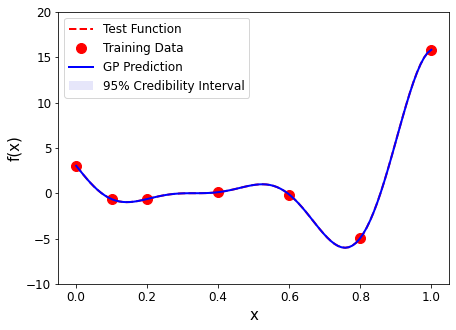

In [10]:
# Assess prediction results
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});

### 1.6 Gradient predictions

The current GEGP package also allows computing the gradients of the output against the inputs. We use `.predict_grad` method to achieve that goal. Notice that the array returned by the `.predict_grad` method is of shape $n_{sample} \times n_{parameters}$, meaning that each row of the array holds the gradient values of the output against individual input parameter at a specific sample location. 

In [11]:
grad_cal = GEGP_1D.predict_grad(X_test)

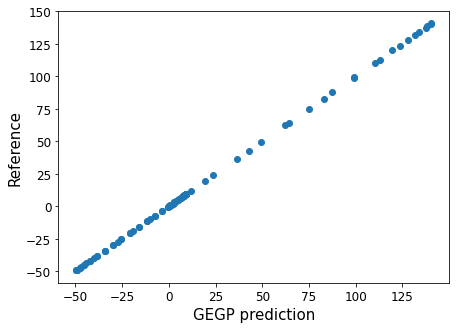

In [12]:
# Assess prediction results
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(grad_cal.flatten(), grad_test.flatten(),'o')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('GEGP prediction', fontsize=15)
ax.set_ylabel('Reference', fontsize=15);

## 2. Test Function (2D)

### 2.1 Nominal value predictions

We further showcase how to train and exploit a gradient-enhanced GP model for multi-dimensional problems. Here, we consider the task of interpolating a two-dimensional analytical function.

\begin{equation}
y = (1-x_1)^2 + 100(x_2-x_1^2)^2, x_1 \in [-2,2] \; x_2 \in [-1,3]
\end{equation}

In [14]:
# 2D Test function
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,[0]])**2 + 100*(X[:,[1]]-X[:,[0]]**2)**2
    
    grad = np.zeros_like(X)
    grad[:,[0]] = 2*(X[:,[0]]-1) - 400*(X[:,[1]]-X[:,[0]]**2)*X[:,[0]]
    grad[:,[1]] = 200*(X[:,[1]]-X[:,[0]]**2)
    
    return y, grad

One thing to keep in mind is that the gradient training data also needs to be properly scaled before feeding into the GEGP training.

In [15]:
def scale_grad(grad, lb, ub, inverse=False):
    """Scale the gradients"""
    if inverse is False:
        # Forward scaling: Converting to [0,1] scale 
        scaled_grad = grad*(ub-lb)     
    else:
        # Inverse scaling: Converting back to original scale 
        scaled_grad = grad/(ub-lb) 
        
    return scaled_grad

### 2.2 Generating training dataset

In [16]:
# Set number of training data
sample_num = 10

# Set parameter space
lb, ub = np.array([-2, -1]), np.array([2, 3])

# Generate random samples (Latin Hypercube sampling)
dimension = [(lb[i],ub[i]) for i in range(len(lb))]
lhs_sampler= Lhs(criterion="maximin")
X_train = np.array(lhs_sampler.generate(dimension, sample_num)) 

# Compute labels
y_train, grad_train = Test_2D(X_train)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test, grad_test = Test_2D(X_test)

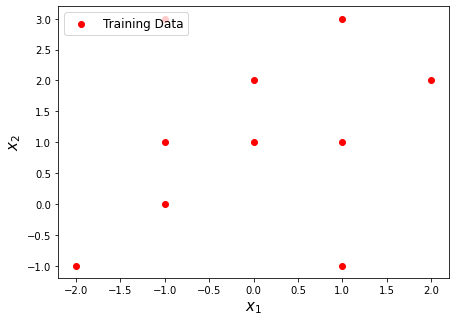

In [17]:
# Inspect sampling
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:,0], X_train[:,1], c='r', label='Training Data')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.legend(loc="upper left",prop={'size': 12});

### 2.3 Normalization

In [18]:
# Normalize training data
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)
grad_train_std = scale_grad(grad_train, lb, ub, inverse=False)

### 2.4 Fitting a GEGP model

In [19]:
# Fit a GEGP model
GEGP_2D = GEGP(n_restarts=40)
GEGP_2D.fit(X_train_std, y_train, grad_train_std.reshape((-1,1), order='F'))

### 2.5 GEGP prediction

In [20]:
# GEGP predictions
y_pred, y_pred_SSqr = GEGP_2D.predict(scaler.transform(X_test))

# Gradient predictions
grad_cal = GEGP_2D.predict_grad(scaler.transform(X_test))

# Scale the gradients back to original scale
grad_cal = scale_grad(grad_cal, lb, ub, inverse=True)

Text(0, 0.5, 'Reference')

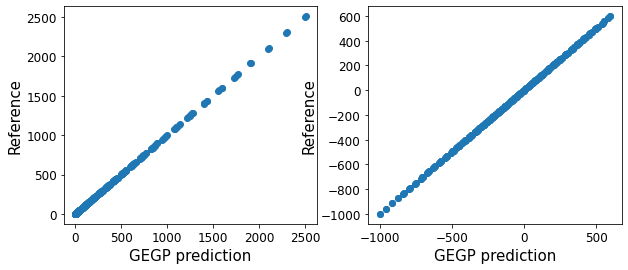

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Check nominal predictions
ax[0].plot(y_pred, y_test.flatten(),'o')
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('GEGP prediction', fontsize=15)
ax[0].set_ylabel('Reference', fontsize=15)

# Check gradient calculations
ax[1].plot(grad_cal[:,1], grad_test[:,1],'o')
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('GEGP prediction', fontsize=15)
ax[1].set_ylabel('Reference', fontsize=15)

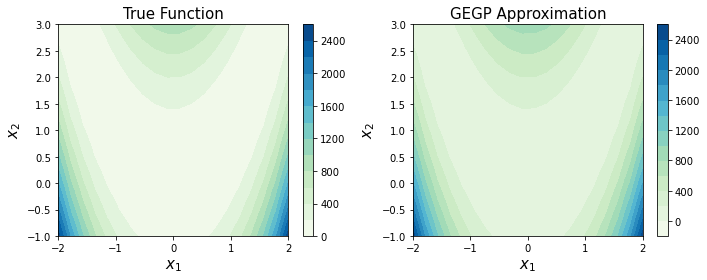

In [22]:
# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GEGP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

### 2.6 Prediction only mode

We can also use the **prediction-only** mode with `.predict_only` method.

In [25]:
# Assigh theta value
custom_theta = GEGP_2D.theta

# Initiate a GEGP model
GEGP_predictor = GEGP()

# Predicting only mode
y_pred, y_pred_SSqr, grad_cal = GEGP_predictor.predict_only(X_train=X_train_std, 
                                                            y_train=y_train, 
                                                            grad_train=grad_train_std.reshape((-1,1), order='F'), 
                                                            theta=custom_theta, 
                                                            X_test=scaler.transform(X_test))

# Scale the gradients back to original scale
grad_cal = scale_grad(grad_cal, lb, ub, inverse=True)

Text(0, 0.5, 'Reference')

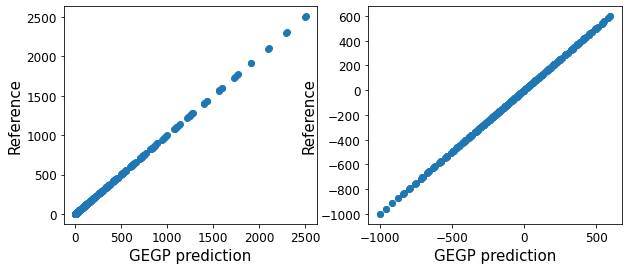

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Check nominal predictions
ax[0].plot(y_pred, y_test.flatten(),'o')
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('GEGP prediction', fontsize=15)
ax[0].set_ylabel('Reference', fontsize=15)

# Check gradient calculations
ax[1].plot(grad_cal[:,1], grad_test[:,1],'o')
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('GEGP prediction', fontsize=15)
ax[1].set_ylabel('Reference', fontsize=15)